#Getting Data from kaggle

In [27]:
from google.colab import files
files.upload()


!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

import zipfile
zip_ref = zipfile.ZipFile('tom-and-jerry-image-classification.zip', 'r')
zip_ref.extractall('/content')

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 99% 430M/435M [00:07<00:00, 116MB/s] 
100% 435M/435M [00:09<00:00, 45.8MB/s]


#Importing Libraries needed for preparing data

In [24]:
import numpy as np
import pandas as pd
import re
import cv2
import seaborn as sns

In [28]:
#Getting images names from Zip file and create list of images names
images_files=zip_ref.infolist()[2:]
list_of_images_name=[]
for i in range(len(images_files)):
  list_of_images_name.append(images_files[i].filename)

len(list_of_images_name)


5478

In [29]:
#Applying function on list of images to match each image with its label in the dataframe
def num_sort(test_string):
    return list(map(int, re.findall('frame(\d+)', test_string)))[0]


list_of_images_name.sort(key=num_sort)

In [30]:
truth=pd.read_csv('/content/ground_truth.csv')
truth.head()

,filename,tom,jerry
0,frame0.jpg,0,0
1,frame1.jpg,0,0
2,frame2.jpg,0,0
3,frame3.jpg,0,0
4,frame4.jpg,0,0


In [31]:
#Adding labels column
def labeling(x,y):
  if x==0 and y==0:
    return 'Not_there'
  elif x==1 and y==0:
    return 'Tom'
  elif x==0 and y==1:
    return 'Jerry'
  else:
    return 'Both'

truth['labels']=truth.apply(lambda x: labeling(x.tom,x.jerry),axis=1)

In [32]:
truth['images']=list_of_images_name

In [33]:
truth.head()

,filename,tom,jerry,labels,images
0,frame0.jpg,0,0,Not_there,tom_and_jerry/tom_and_jerry/tom_jerry_0/frame0...
1,frame1.jpg,0,0,Not_there,tom_and_jerry/tom_and_jerry/tom_jerry_0/frame1...
2,frame2.jpg,0,0,Not_there,tom_and_jerry/tom_and_jerry/tom_jerry_0/frame2...
3,frame3.jpg,0,0,Not_there,tom_and_jerry/tom_and_jerry/tom_jerry_0/frame3...
4,frame4.jpg,0,0,Not_there,tom_and_jerry/tom_and_jerry/tom_jerry_0/frame4...


<Axes: xlabel='labels', ylabel='count'>

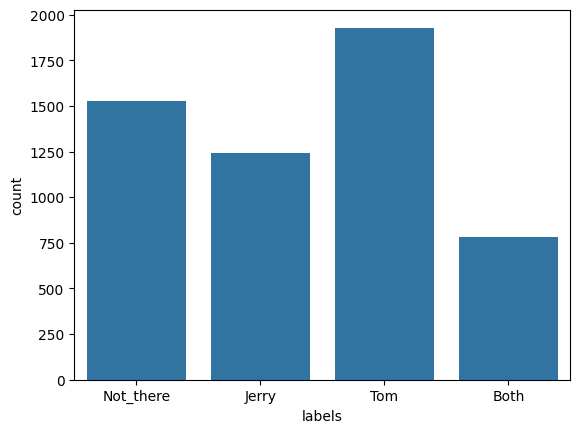

In [34]:
sns.countplot(x=truth['labels'])

In [ ]:
#Shuffling the rows of he dataframe
truth = truth.sample(frac=1).reset_index(drop=True)

In [ ]:
truth.head()

,filename,tom,jerry,labels,images
0,frame171.jpg,1,0,Tom,tom_and_jerry/tom_and_jerry/tom/frame171.jpg
1,frame4576.jpg,0,1,Jerry,tom_and_jerry/tom_and_jerry/jerry/frame4576.jpg
2,frame3886.jpg,0,1,Jerry,tom_and_jerry/tom_and_jerry/jerry/frame3886.jpg
3,frame4666.jpg,0,0,Not_there,tom_and_jerry/tom_and_jerry/tom_jerry_0/frame4...
4,frame2898.jpg,0,1,Jerry,tom_and_jerry/tom_and_jerry/jerry/frame2898.jpg


In [ ]:
#Encoding the labels
labels_dictionary={'Not_there':0,'Tom':1,'Jerry':2,'Both':3}
list_of_labels=list(truth['labels'])
labels = [labels_dictionary[label] for label in list_of_labels]

In [ ]:
set(labels)

{0, 1, 2, 3}

In [ ]:
#Creating labels array
labels_array=np.array(labels)

In [ ]:
#Creating List of images
images_list=list(truth['images'])
len(images_list)

5478

In [ ]:
#Creating function for read, resize and creating images array
def images_preprocessing(list_of_images):
  images_data=[]
  for image in list_of_images:
    read_image=cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    read_image=cv2.resize(read_image,(224,224))
    images_data.append(read_image)
  images_data=np.array(images_data)
  return images_data




In [ ]:
images_data_array=images_preprocessing(images_list)

In [ ]:
images_data_array.shape,labels_array.shape

((5478, 224, 224, 3), (5478,))

In [ ]:
#Saving images and labels array for reuse to avoid crashing of the notebook
np.save("/content/drive/MyDrive/images_data_array", images_data_array)
np.save("/content/drive/MyDrive/labels_array", labels_array)

In [21]:
#Start a new run
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
import cv2
import random
import tensorflow as tf
from keras.models import Sequential
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [2]:
#Loading images and labels array
images_final_array = np.load("/content/drive/MyDrive/images_data_array.npy")
labels_final_array = np.load("/content/drive/MyDrive/labels_array.npy")

In [3]:
images_final_array.shape,labels_final_array.shape

((5478, 224, 224, 3), (5478,))

In [4]:
#Splitting data into training and testing
x_training_set=images_final_array[:4382]
x_test_set=images_final_array[4382:]
y_training_set=labels_final_array[:4382]
y_test_set=labels_final_array[4382:]

In [5]:
x_training_set.shape,y_training_set.shape,x_test_set.shape,y_test_set.shape

((4382, 224, 224, 3), (4382,), (1096, 224, 224, 3), (1096,))

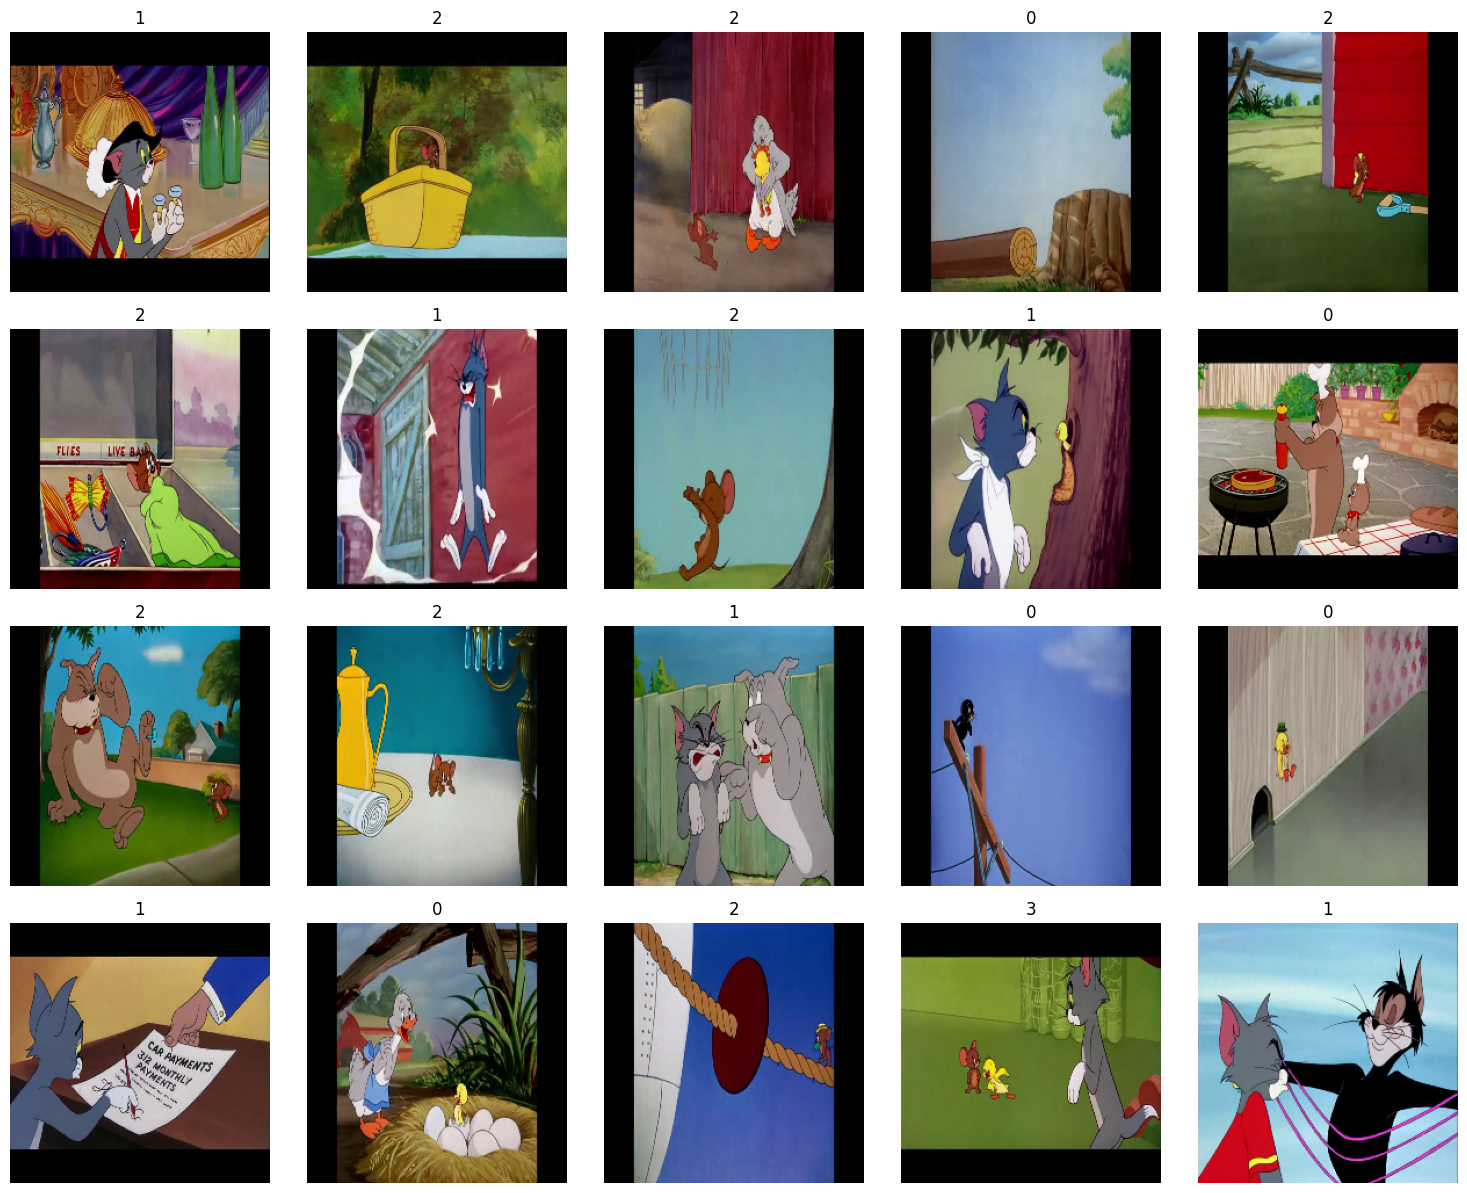

In [6]:
#Plotting random images from data
plt.figure(figsize = (15, 15))
plotnumber = 1

for i in range(21):
    if plotnumber <= 20:
        ax = plt.subplot(5, 5, plotnumber)
        plt.imshow(x_training_set[i], cmap = 'binary')
        plt.axis('off')
        plt.title(y_training_set[i], fontdict = {'fontsize'  : 12, 'color' : 'black'})

    plotnumber += 1

plt.tight_layout()
plt.show()

In [7]:
#Applying data augmentation to avoid overfitting as the data is small
train_datagen = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [8]:
train_generator = train_datagen.flow(
    x=x_training_set,
    y=y_training_set,
    batch_size=64
)

In [ ]:
sample_of_x=x_training_set[200].reshape(1,224,224,3)
sample_of_y=y_training_set[200].reshape(1,1)
example_generator = train_datagen.flow(
    x=sample_of_x,
    y=sample_of_y,
)


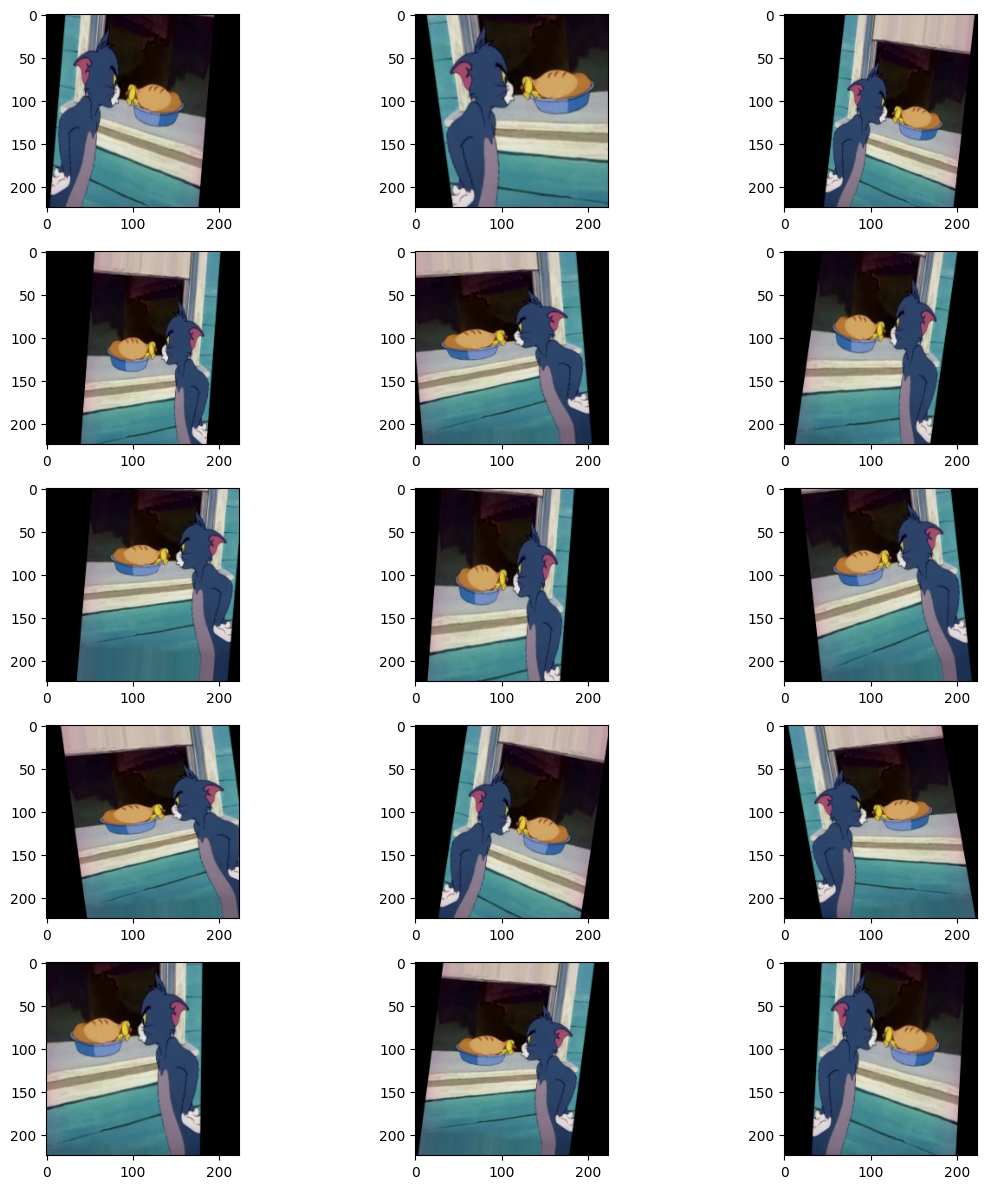

In [ ]:
#Showing sample of augmentation applied on images
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image.astype('uint8'))
        break
plt.tight_layout()
plt.show()

In [9]:
#using Resnet50 (Transfer learning)
Res_model=ResNet50(weights='imagenet',
                include_top=False,
                input_shape=(224,224,3))

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
Res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
Res_model.layers[20].output

<KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'conv2_block2_1_bn')>

In [11]:
#Creating model and tuning the last layers
for layer in Res_model.layers:
  layer.trainable=False

#last layers output
x=Res_model.layers[20].output
x=Conv2D(256,kernel_size=5,activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPooling2D(pool_size=2)(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.25)(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.25)(x)
x=Dense(4,activation='softmax')(x)



Res_model_transfer=Model(inputs=Res_model.input,outputs=x)


In [12]:
Res_model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [13]:
Res_model_transfer.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                           metrics='accuracy')

history = Res_model_transfer.fit_generator(
    train_generator,
    epochs=40,
    validation_data=(x_test_set,y_test_set),
)

<ipython-input-13-9e65103417a3>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Res_model_transfer.fit_generator(


Epoch 1/40
69/69 [==============================] - 80s 1s/step - loss: 1.5876 - accuracy: 0.3827 - val_loss: 3.7205 - val_accuracy: 0.3266
Epoch 2/40
69/69 [==============================] - 65s 940ms/step - loss: 1.2576 - accuracy: 0.4569 - val_loss: 1.7129 - val_accuracy: 0.4115
Epoch 3/40
69/69 [==============================] - 66s 962ms/step - loss: 1.0628 - accuracy: 0.5436 - val_loss: 1.0858 - val_accuracy: 0.5703
Epoch 4/40
69/69 [==============================] - 61s 885ms/step - loss: 0.9435 - accuracy: 0.6002 - val_loss: 1.1199 - val_accuracy: 0.5584
Epoch 5/40
69/69 [==============================] - 56s 819ms/step - loss: 0.8518 - accuracy: 0.6419 - val_loss: 1.0730 - val_accuracy: 0.5876
Epoch 6/40
69/69 [==============================] - 63s 923ms/step - loss: 0.7611 - accuracy: 0.6894 - val_loss: 0.7712 - val_accuracy: 0.6980
Epoch 7/40
69/69 [==============================] - 55s 799ms/step - loss: 0.7036 - accuracy: 0.7095 - val_loss: 0.9453 - val_accuracy: 0.6524
Ep

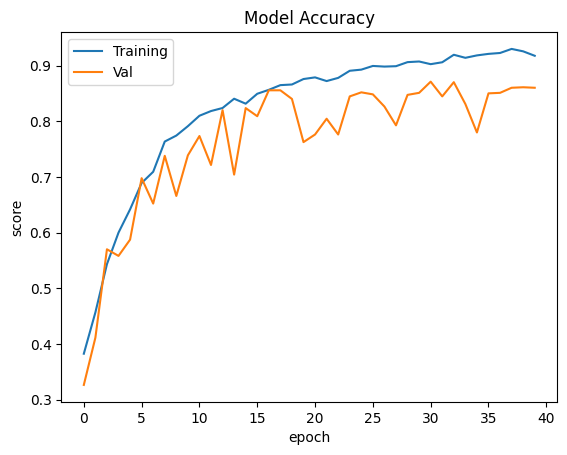

In [14]:
#Plotting accuracy of training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Training','Val'],loc='upper left')
plt.show()

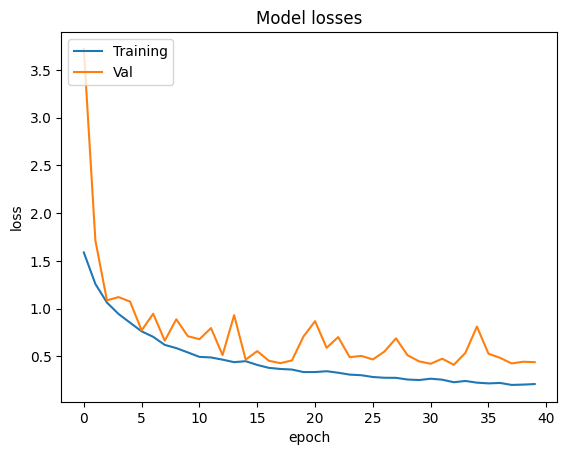

In [15]:
#Plotting losses of training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training','Val'],loc='upper left')
plt.show()

In [16]:
y_probs = Res_model_transfer.predict(x_test_set)
y_preds = y_probs.argmax(axis=1)
y_preds[:100]

35/35 [==============================] - 1s 26ms/step


array([3, 3, 0, 1, 3, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 3, 1, 2, 2,
       1, 1, 0, 1, 1, 3, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0,
       2, 1, 1, 3, 1, 1, 0, 1, 2, 2, 3, 3, 1, 3, 0, 0, 2, 1, 1, 1, 1, 0,
       1, 2, 1, 1, 3, 1, 3, 1, 2, 3, 0, 2, 3, 3, 2, 1, 1, 1, 0, 1, 1, 1,
       2, 3, 2, 0, 2, 1, 1, 1, 3, 2, 1, 0])

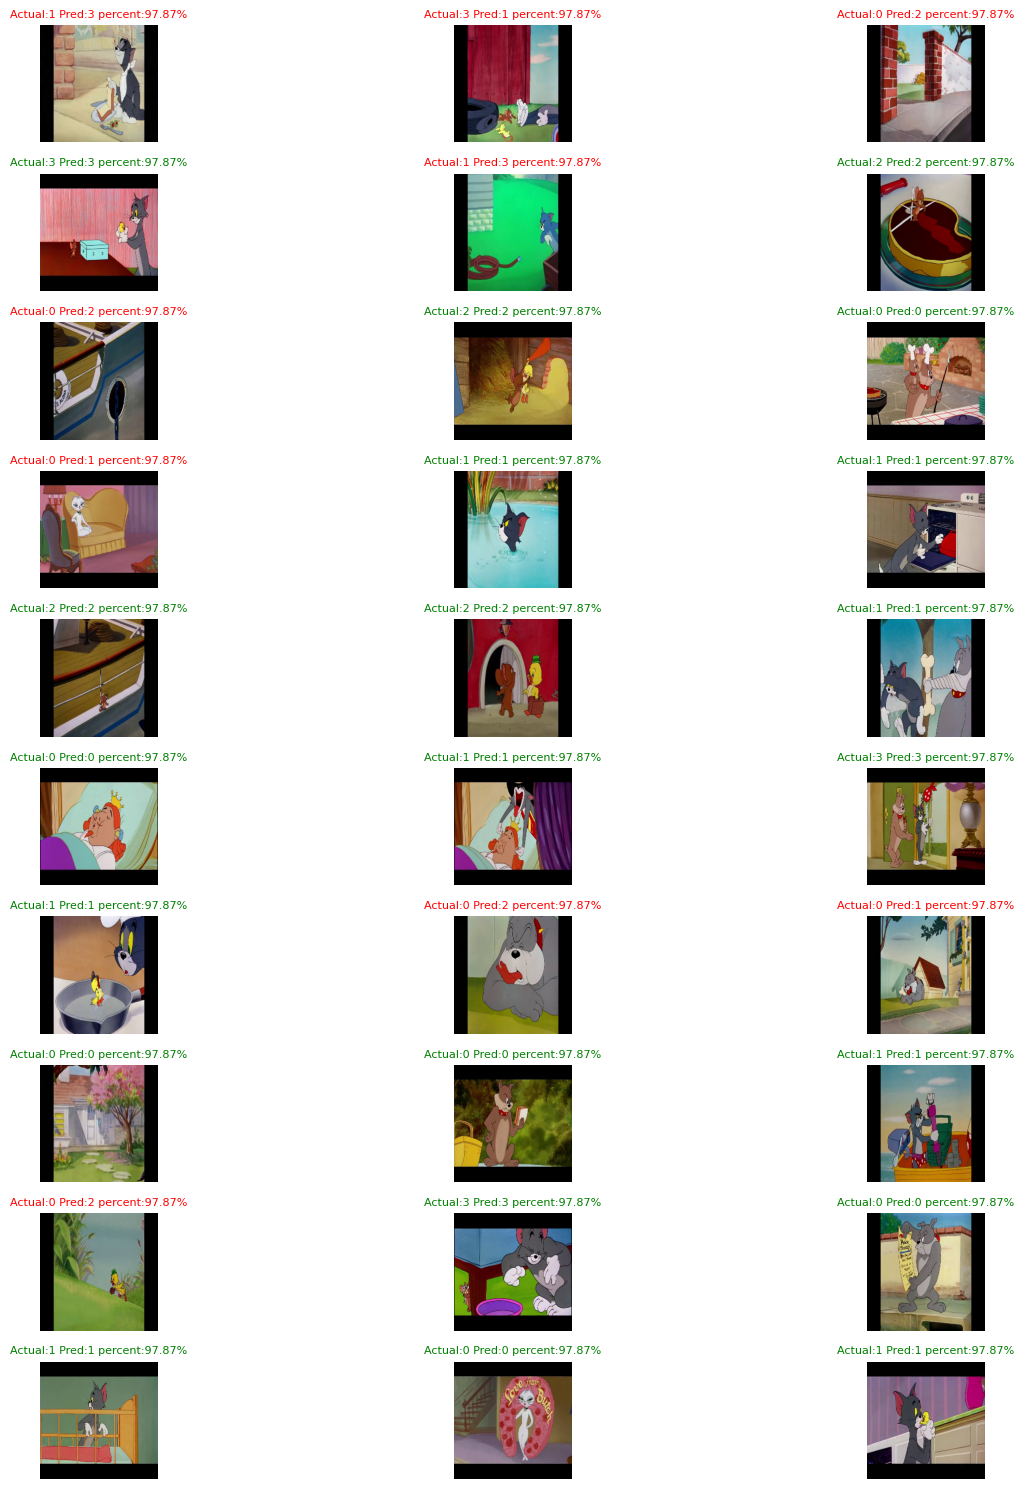

In [23]:
plt.figure(figsize = (15, 15))
plotnum=1
for i in range(31):
  random_num=random.randint(0,len(x_test_set))
  if plotnum<=30:
    ax=plt.subplot(10,3,plotnum)
    plt.imshow(x_test_set[random_num],cmap='binary')
    plt.axis('off')
    if y_test_set[random_num]==y_preds[random_num]:
      plt.title(f'Actual:{y_test_set[random_num]} Pred:{y_preds[random_num]} percent:{round(100*tf.reduce_max(y_probs[0]).numpy(),2)}%',
                 fontdict = {'fontsize'  : 8, 'color' : 'green'})

    else:
      plt.title(f'Actual:{y_test_set[random_num]} Pred:{y_preds[random_num]} percent:{round(100*tf.reduce_max(y_probs[0]).numpy(),2)}%',
                 fontdict = {'fontsize'  : 8, 'color' : 'red'})

  plotnum+=1

plt.tight_layout()